In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from scipy.signal import medfilt

import sys
sys.path.append("/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev")
from misc import *

In [2]:
"""
NOTE: 
the window size (ws) of 12 still does not get rid of trees blowing in the wind. 
There is still the problem concerning the cyclical noise in the activation array. 

trees blowing soln ides: 
 - filter
 - smooth
 - suck it up and deal with it later
 - later we could use peaks in the image to id points and maybe blobs
 --- we could then check to see if those blobs are wolves or not
 
cyclical noise soln idea: 
 - change window size to see if that affects activation arr
 - suck it up 
 - model the noise over time. Try to figure out what that signal is
 --- and then filter that noise out. Maybe get different frequencies 
 --- over time 

"""

'\nNOTE: \nthe window size (ws) of 12 still does not get rid of trees blowing in the wind. \nThere is still the problem concerning the cyclical noise in the activation array. \n\ntrees blowing soln ides: \n - filter\n - smooth\n - suck it up and deal with it later\n - later we could use peaks in the image to id points and maybe blobs\n --- we could then check to see if those blobs are wolves or not\n \ncyclical noise soln idea: \n - change window size to see if that affects activation arr\n - suck it up \n - model the noise over time. Try to figure out what that signal is\n --- and then filter that noise out. Maybe get different frequencies \n --- over time \n\n'

In [3]:
# the window size (ws) has been determined from experimental analysis
# the ws corresponds to the number of frames needed to create an effective
# std dev frame. Given a 12 frames, taking the std of these gives a useful 
# output that can be used for wolf detection
WINDOW_SIZE = 12

In [4]:
# basic wolf video 
wolf_dir = "/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF"

# list of wolf video files
wolf_vid_fs = glob(wolf_dir + "/*")


In [5]:
def create_std_vid(vid, f_name = None, window_size = WINDOW_SIZE):
    """creates a 4D array from a windowed standard deviation of a video
    
    Parameters
    ----------
    vid: np array of a video 
        (use load_video(file_name) to get arr)
    f_name: string used to save file if needed
    window_size: int | 12 (WINDOW_SIZE) has been found to be optimal
    
    Returns
    -------
    standard deviation video array
    
    """
    
    # window size
    ws = window_size
    
    # the last and first frame will be copied 

    # pad the video to account for the window size
    padded_video = np.zeros(((vid.shape[0] - 4 + 2 * ws), vid.shape[1], vid.shape[2]),\
                            dtype = np.int16)
    """
    padded video example:
    [0, 0, 0, ... #, #, #, ..., 0, 0, 0]
    
    """
    
    
    # fill the padded video 
    padded_video[(ws-2) : vid.shape[0] + (ws-2), ...] = vid.copy()

    # copy first frame of video to beginning frames of padded_video
    padded_video[:(ws-2)] = vid[0].copy()
    
    # copy last frame of video to the end frames of the padded_video 
    padded_video[vid.shape[0] + (ws-2):, ...] = vid[-1].copy()

    # std dev video creation
    std_v = np.zeros(vid.shape, dtype = np.int16)
    
    for i in range(0, std_v.shape[0]):
        # calculate standard dev of a windowed sample
        std_frame = np.std(padded_video[i:i+ws], axis = 0)
        
        # normalize values into 0-255
        std_frame /= std_frame.max()
        std_frame *= 255
        std_v[i] = std_frame.copy()
    
    if f_name:
        save_video(std_v,f_name, fps = 60)
        
    return std_v

In [6]:
def get_activation_in_frames(vid_arr):
    """
    gets the activation and sparsity of the video array
    
    activation calculation: 
    - sum(pixel values in frame)/(frame area)
    
    sparsity calculation:
    - 
    
    Parameters
    ----------
    vid_arr: array
    
    Return
    ------
    activation_arr: arr
    sparsity_arr: arr 
    
    """
    # sum colors for each frame
    vid_arr = vid_arr/np.max(vid_arr)
    activation_arr = np.zeros(vid_arr.shape[0])
    
    sparsity_arr = np.zeros(vid_arr.shape[0])

    # memory constant
    mem_lambda = .3
    
    # moving average sum
    mv_sum = 0
    
    frame_area = (vid_arr.shape[1]*vid_arr.shape[2])
    
    for i, frame in enumerate(vid_arr):
        frame = vid_arr[i]
        # get activation in frame
        frame_activation = np.sum(frame)/frame_area
        
        # measure pixel 'sparsity' 
        # get sum of pixel values along x axis
        x_sum = np.sum(frame, 0)
        # create index array of x axis
        x_idx = np.arange(0, frame.shape[1])
        
        # calculate standard dev for pixels in that axis
        x_x = x_sum * x_idx
        x_std = np.std(x_x)
        
        # see comments above
        y_sum = np.sum(frame, 1)
        y_idx = np.arange(0, frame.shape[0])
        y_y = y_sum * y_idx
        y_std = np.std(y_y)
        
        sparsity = (x_std + y_std)/2
        
        sparsity_arr[i] = sparsity
        activation_arr[i] = frame_activation

    # normalize arrays by max value to represent values between 0-1
    sparsity_arr /= sparsity_arr.max()
    activation_arr /= activation_arr.max()
    
    return activation_arr, sparsity_arr

In [7]:
if input("new video?\n") == "yes":
    random_idx = np.random.randint(0,200)
    test_vid_f = wolf_vid_fs[random_idx]

    print(test_vid_f)

    vid = load_video(test_vid_f, frames = 10*60)

    vid = decrease_res_by_x(vid, int(vid.shape[2]/4), int(vid.shape[1]/4))
    vid = vid.astype(np.int16)

new video?
 


In [12]:
def frame_filter(video, debug = False): 
    """
    frame_filter function
    input: video (numpy array)
    output: filtered video (numpy array), std dev vid, smoothed activation arr
    """
    # get windowed std dev
    std_v = create_std_vid(vid, window_size = 12)
    # threshold to get rid of low value noise 
    std_v[std_v <= 150] = 0
    
    # activation_arr -> sum of pixel values for each frame
    # sparsity_arr -> sparsity for each frame
    activation_arr, sparsity_arr = get_activation_in_frames(std_v)
    

    # LOOK AT THIS LINE. WHAT IF I FLIPPED THE SMOOTHING AND SPARSITY SUPPRESSION
    # if there is a wolf, add a second to the video
    
    # any frames that are too sparse probably have noise or wind
    # adjust activation accordingly
    activation_arr *= (1-sparsity_arr)**2 # what happens if I square it?
    
    # smoothing window
    N = 20
    # moving average to smooth the activation arr
    act_smoothed = np.convolve(activation_arr, np.ones(N)/N, mode='same')
    
    # frame filter activation threshold
    FF_act_thresh = 0.15
    
    # frames that might have wolves
    valid_frames = np.where(act_smoothed > FF_act_thresh)
    
    if debug: 
        frame_idx = np.arange(0, act_smoothed.shape[0])/60
        ran = range(0, frame_idx.shape[0])
        plt.plot(frame_idx[ran], act_smoothed[ran], label = "activation")
        plt.plot(frame_idx[ran], sparsity_arr[ran], label = "sparsity")
        plt.legend()
        plt.ylabel("%")
        plt.xlabel("seconds")
        plt.show()
    
    return video[valid_frames], std_v, act_smoothed

/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0124.MP4


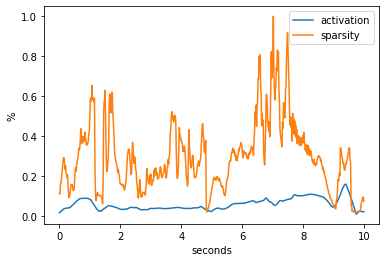

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/0_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/0_activation_vid.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0195.MP4


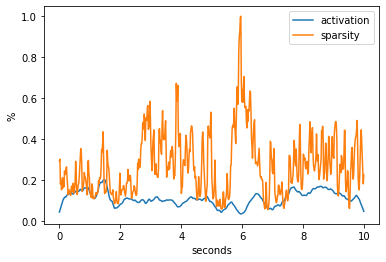

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/1_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/1_activation_vid.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/1_vid_filt.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0027.MP4


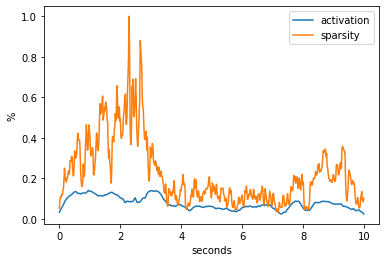

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/2_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/2_activation_vid.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0166.MP4


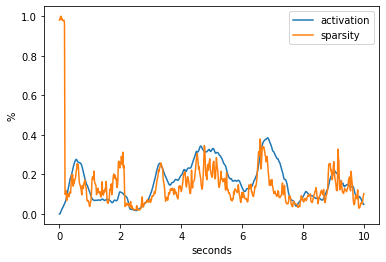

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/3_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/3_activation_vid.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/3_vid_filt.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0107.MP4


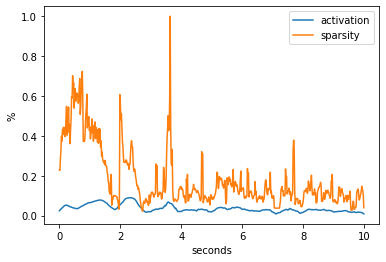

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/4_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/4_activation_vid.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0072.MP4


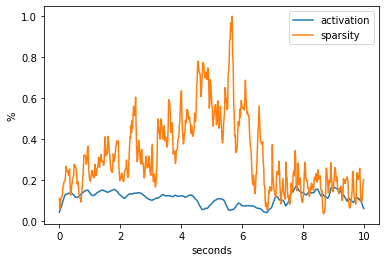

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/5_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/5_activation_vid.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/5_vid_filt.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0192.MP4


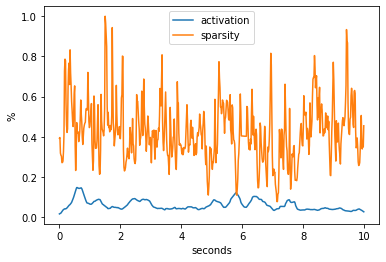

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/6_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/6_activation_vid.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0169.MP4


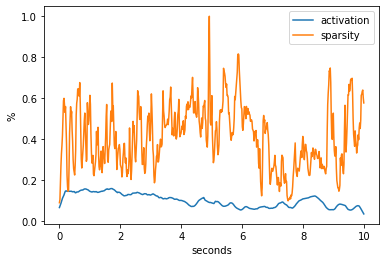

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/7_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/7_activation_vid.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/7_vid_filt.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0053.MP4


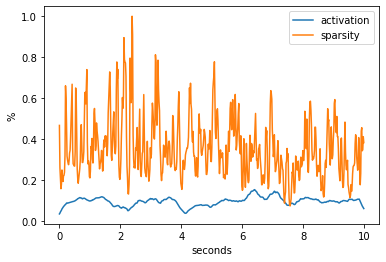

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/8_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/8_activation_vid.mp4
/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0134.MP4


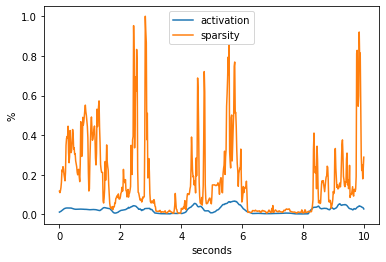

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/9_vid_raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/9_activation_vid.mp4


In [13]:
 for i in range(10):
    random_idx = np.random.randint(0,200)
    test_vid_f = wolf_vid_fs[random_idx]

    print(test_vid_f)

    vid = load_video(test_vid_f, frames = 10*60)
    vid = decrease_res_by_x(vid, int(vid.shape[2]/4), int(vid.shape[1]/4))
    vid = vid.astype(np.int16)
    ff_vid, std_vid, act_smoothed = frame_filter(vid, debug = True)
    
    save_video(vid, f"{i}_vid_raw")
    act_arr = act_smoothed/np.max(act_smoothed)
    save_video_w_mvmt_annotations(std_vid, act_arr, f"{i}_activation_vid", fps = 60)
    if ff_vid.shape[0] > 5:
        save_video(ff_vid, f"{i}_vid_filt")

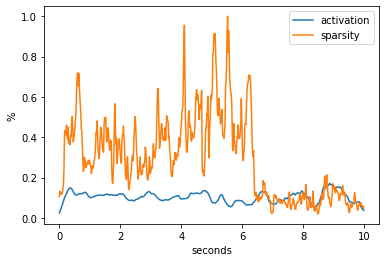

In [10]:
ff_vid, std_vid, act_smoothed = frame_filter(vid, debug = True)

In [11]:
save_video(vid, "raw")
act_arr = act_smoothed/np.max(act_smoothed)
save_video_w_mvmt_annotations(std_vid, act_arr, "std_w_activation", fps = 60)

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/std_w_activation.mp4
